In [1]:
# Referecne : https://www.kaggle.com/code/farzadnekouei/imbalanced-garbage-classification-resnet50/notebook

In [ ]:
import os
import tensorflow as tf

# GPU 1만 사용하도록 환경 변수 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 설정 후, TensorFlow가 사용할 수 있는 GPU 확인
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix


2024-10-22 16:28:52.079713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 16:28:52.577396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
root_dir = '/hdd1/lim_data/level2_dataset'

train_df = pd.read_csv("/hdd1/lim_data/level2_dataset/csv/train_4.csv")
train_df.columns = ['label', 'filepath', 'label_id']
new_columns = ['filepath', 'label', 'label_id']

train_df['filepath'] = train_df['filepath'].apply(lambda x: os.path.join(root_dir, x))
train_df = train_df[new_columns]

val_df = pd.read_csv("/hdd1/lim_data/level2_dataset/csv/val_4.csv")
val_df.columns = ['label', 'filepath', 'label_id']
new_columns = ['filepath', 'label', 'label_id']

val_df['filepath'] = val_df['filepath'].apply(lambda x: os.path.join(root_dir, x))
val_df = val_df[new_columns]

In [5]:
train_df.head()

filepath        label  label_id
0  /hdd1/lim_data/level2_dataset/crop_train_4/1_1...        Metal         3
1  /hdd1/lim_data/level2_dataset/crop_train_4/1_2...  Plastic bag         7
2  /hdd1/lim_data/level2_dataset/crop_train_4/1_3...        Glass         4
3  /hdd1/lim_data/level2_dataset/crop_train_4/1_4...      Plastic         5
4  /hdd1/lim_data/level2_dataset/crop_train_4/1_5...      Plastic         5

In [6]:
val_df.head()

filepath          label  label_id
0  /hdd1/lim_data/level2_dataset/crop_val_4/4_13_...          Paper         1
1  /hdd1/lim_data/level2_dataset/crop_val_4/4_14_...          Paper         1
2  /hdd1/lim_data/level2_dataset/crop_val_4/4_15_...          Paper         1
3  /hdd1/lim_data/level2_dataset/crop_val_4/4_16_...          Paper         1
4  /hdd1/lim_data/level2_dataset/crop_val_4/4_17_...  General trash         0

In [7]:
# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))


Class distribution in the training set:

label
Paper            27.67
Plastic bag      22.20
General trash    16.97
Plastic          12.77
Styrofoam         5.76
Glass             4.10
Metal             3.97
Paper pack        3.88
Clothing          2.00
Battery           0.68
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
Paper            26.47
Plastic bag      23.12
General trash    17.84
Plastic          12.50
Glass             4.84
Metal             4.38
Styrofoam         4.15
Paper pack        3.85
Clothing          2.11
Battery           0.73
Name: proportion, dtype: float64


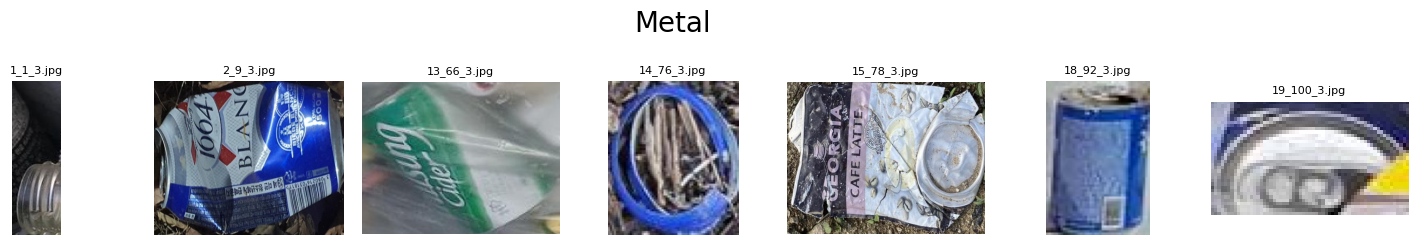

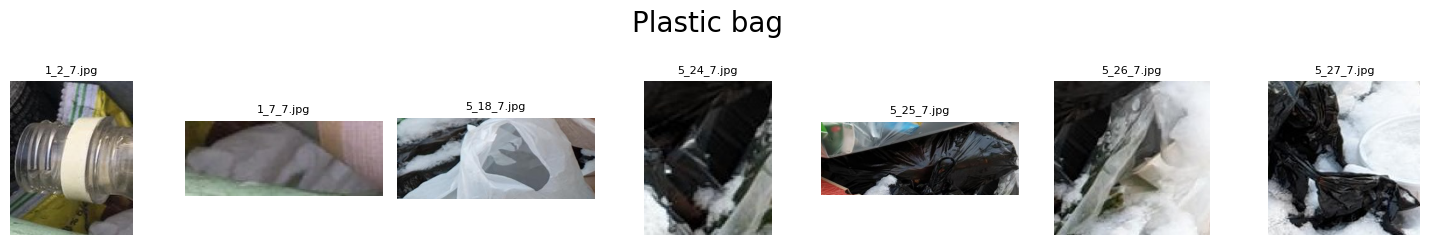

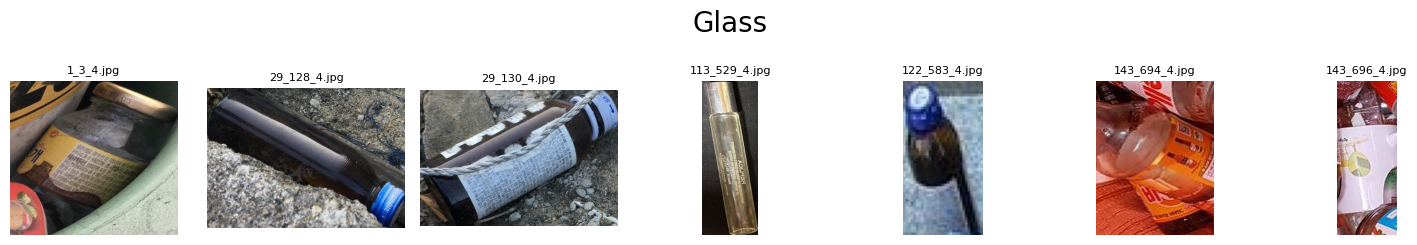

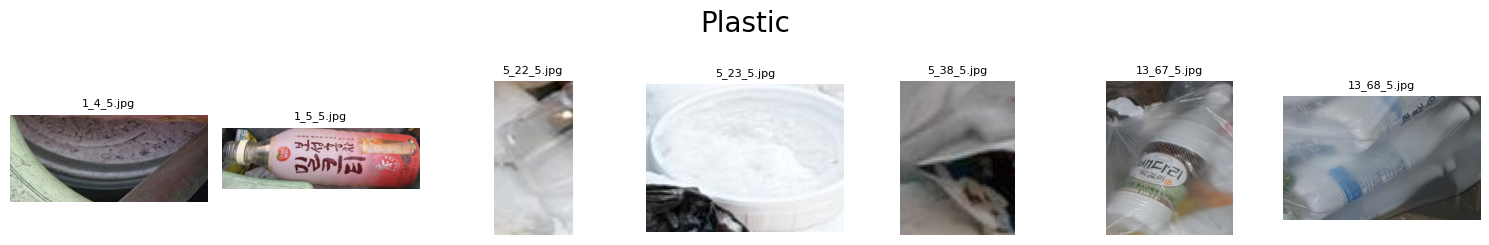

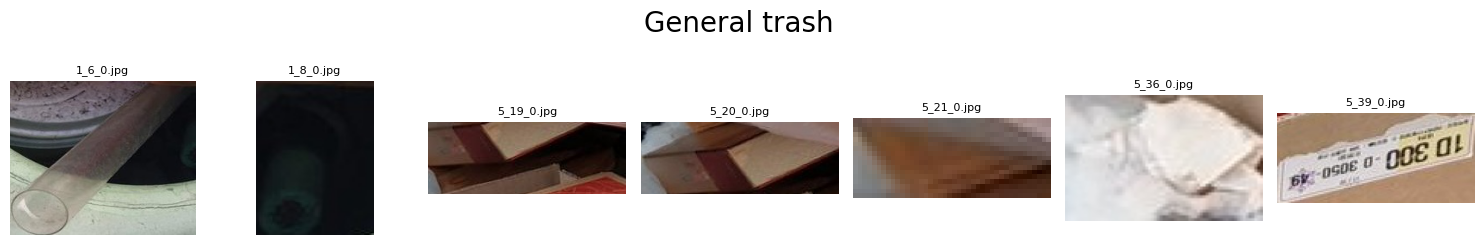

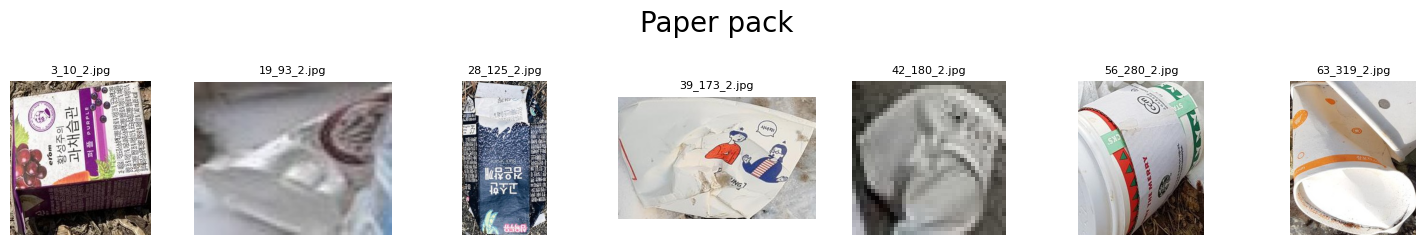

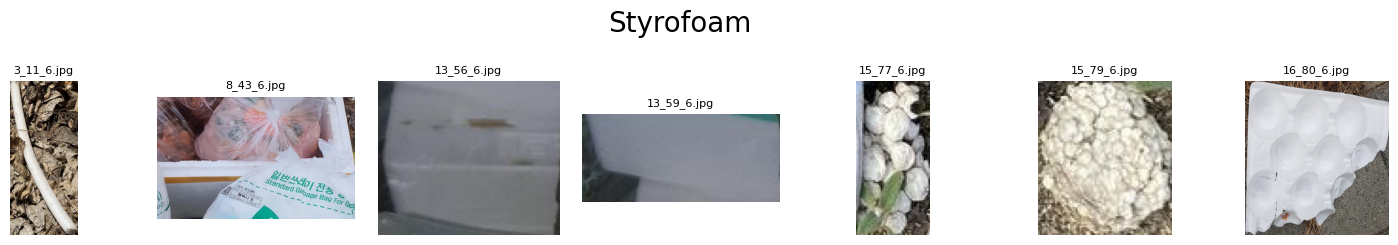

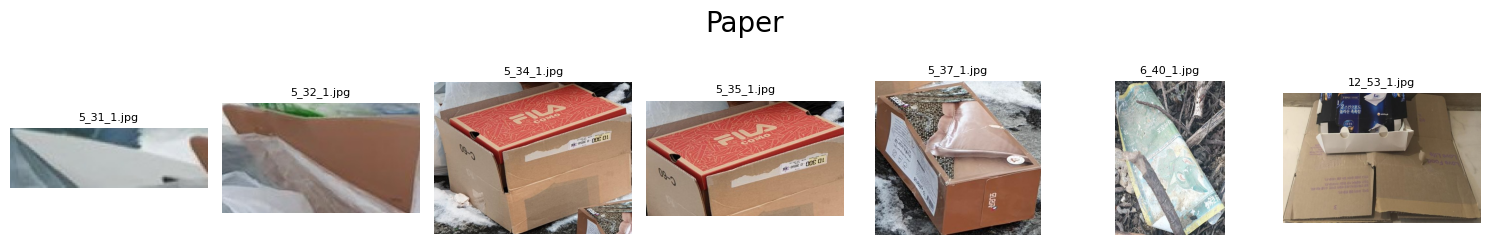

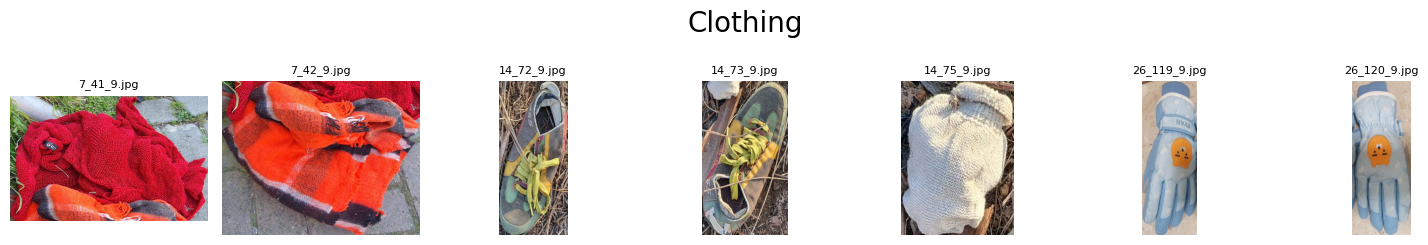

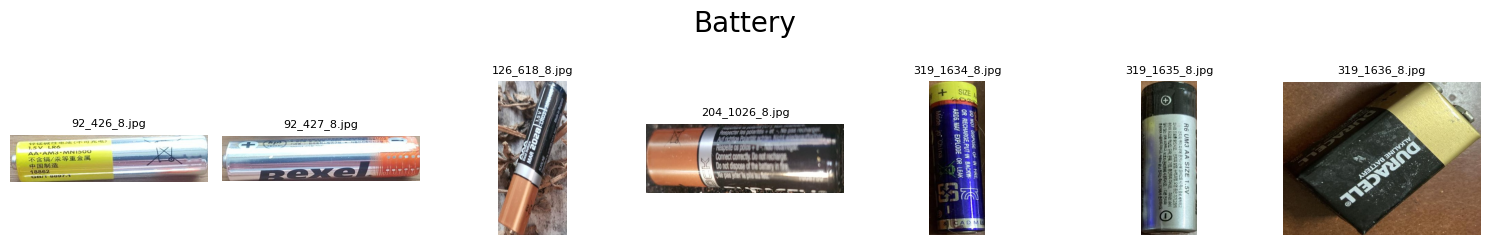

In [8]:
# 고유한 garbage_type (label)을 가져오기
garbage_types = train_df['label'].unique()

# Iterate over each trash type (label) to display images
for garbage_type in garbage_types:
    # 해당 라벨에 해당하는 데이터 필터링
    filtered_df = train_df[train_df['label'] == garbage_type]
    
    # 첫 7개의 이미지 경로 선택
    image_files = filtered_df['filepath'].values[:7]
    
    # Set up subplots
    fig, axs = plt.subplots(1, len(image_files), figsize=(15, 2))
    
    for i, image_file in enumerate(image_files):

        file_name = os.path.basename(image_file)
        with Image.open(image_file) as img:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(file_name, fontsize=8)
    
    plt.tight_layout()
    fig.suptitle(garbage_type, fontsize=20, y=1.2)
    plt.show()

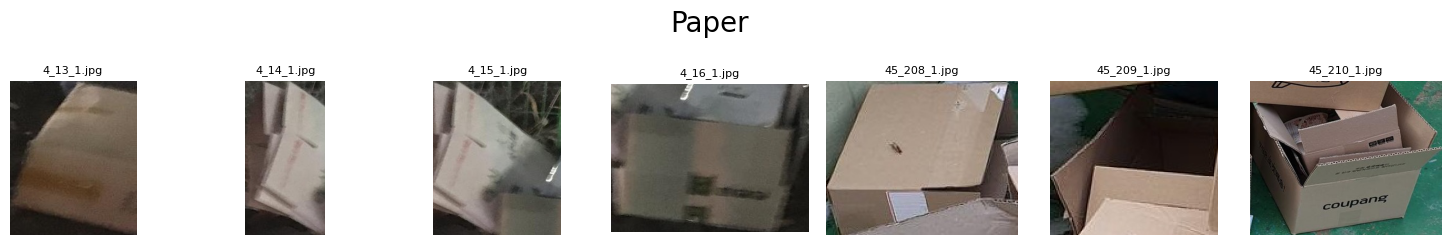

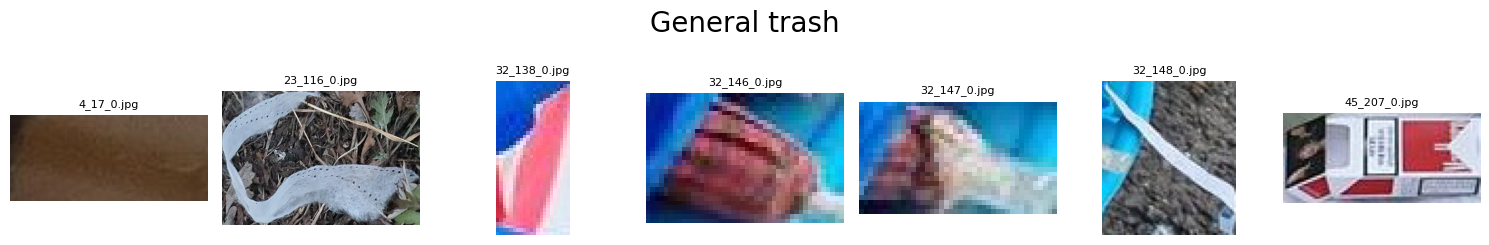

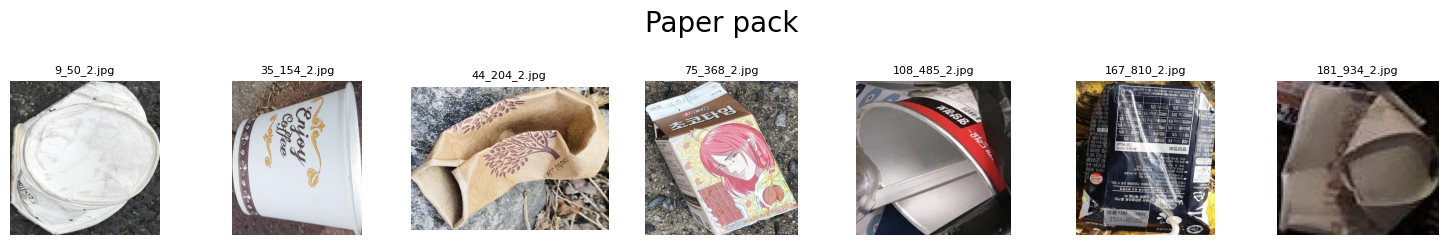

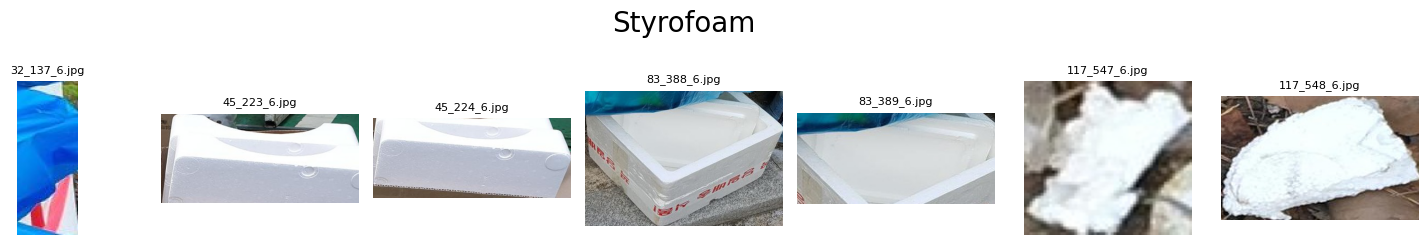

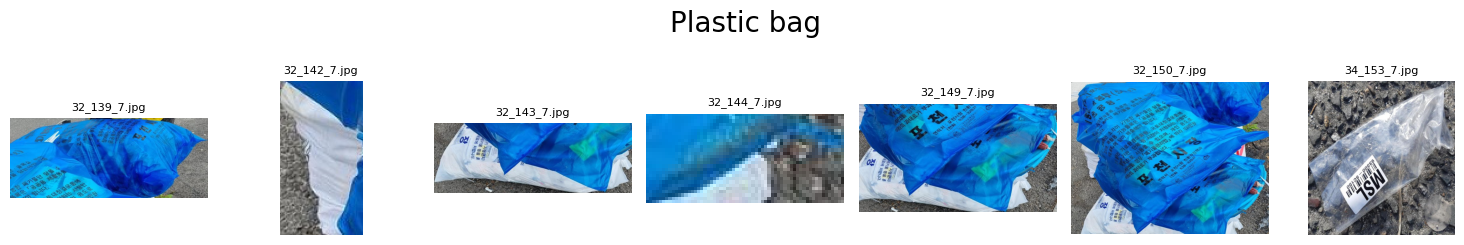

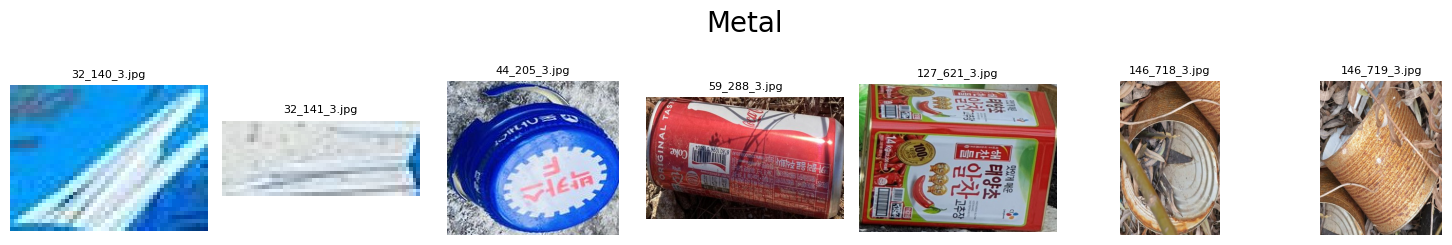

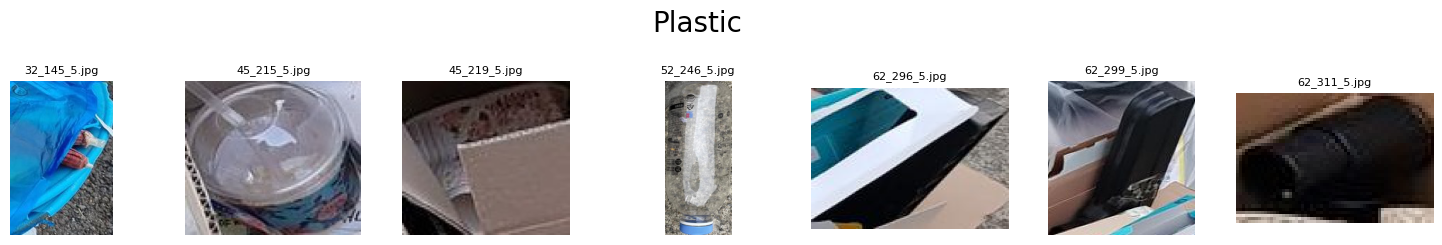

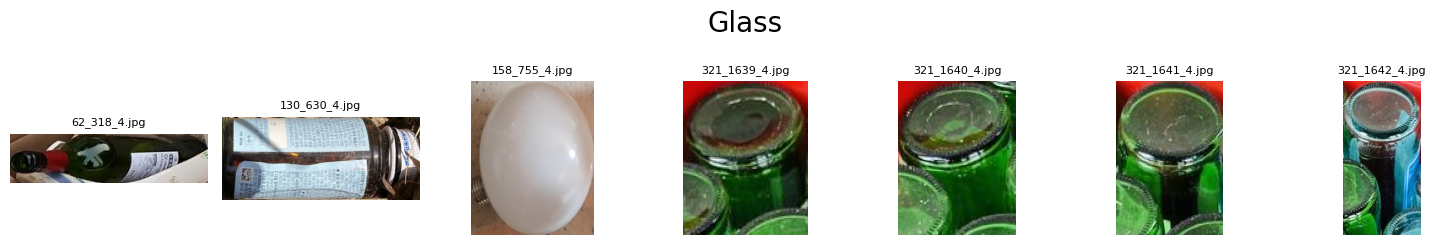

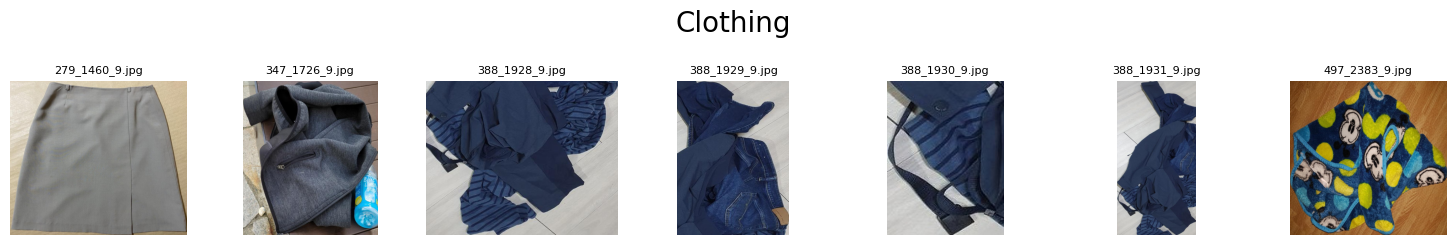

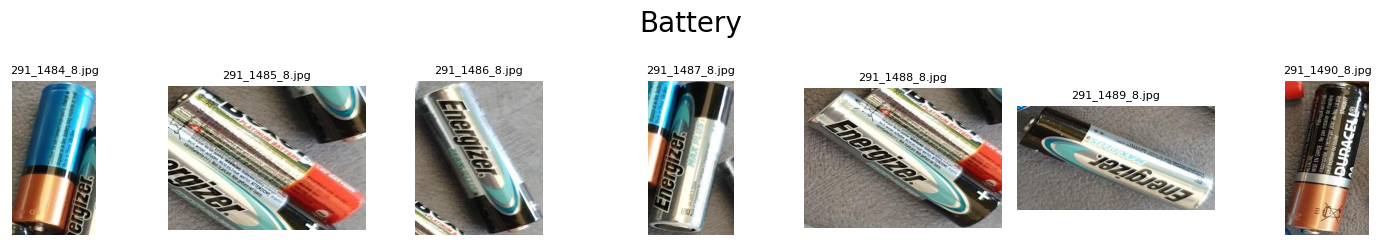

In [9]:
# 고유한 garbage_type (label)을 가져오기
garbage_types = val_df['label'].unique()

# Iterate over each trash type (label) to display images
for garbage_type in garbage_types:
    # 해당 라벨에 해당하는 데이터 필터링
    filtered_df = val_df[val_df['label'] == garbage_type]
    
    # 첫 7개의 이미지 경로 선택
    image_files = filtered_df['filepath'].values[:7]
    
    # Set up subplots
    fig, axs = plt.subplots(1, len(image_files), figsize=(15, 2))
    
    for i, image_file in enumerate(image_files):

        file_name = os.path.basename(image_file)
        with Image.open(image_file) as img:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(file_name, fontsize=8)
    
    plt.tight_layout()
    fig.suptitle(garbage_type, fontsize=20, y=1.2)
    plt.show()

In [90]:
# # 일반학습

# # Slight Augmentation settings for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255,                     # Normalize pixel values to [0,1]
#     rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
#     width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
#     height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
#     zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
#     horizontal_flip=True,               # Randomly flip images horizontally
#     vertical_flip=True,                 # Randomly flip images vertically
#     shear_range=0.05,                   # Apply slight shear transformations
#     brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
#     channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
#     fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
# )

# # Only rescaling for validation
# val_datagen = ImageDataGenerator(rescale=1./255)

In [91]:
# # 일반 학습

# # Using flow_from_dataframe to generate batches
# # Generate training batches from the training dataframe
# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,                  # DataFrame containing training data
#     x_col="filepath",                    # Column with paths to image files
#     y_col="label_id",                    # Column with image labels
#     target_size=(384, 384),              # Resize all images to size of 384x384
#     batch_size=32,                       # Number of images per batch
#     class_mode='raw',                    # One-hot encode labels
#     seed=42,                             # Seed for random number generator to ensure reproducibility
#     shuffle=False                        # Data is not shuffled; order retained from DataFrame
# )


# # Generate validation batches from the validation dataframe
# val_generator = val_datagen.flow_from_dataframe(
#     dataframe=val_df,                    # DataFrame containing validation data
#     x_col="filepath",                    # Column with paths to image files
#     y_col="label_id",                       # Column with image labels
#     target_size=(384, 384),              # Resize all images to size of 384x384
#     batch_size=32,                       # Number of images per batch
#     class_mode='raw',                    # One-hot encode labels
#     seed=42,                             # Seed for random number generator to ensure reproducibility
#     shuffle=False                        # Data is not shuffled; order retained from DataFrame
# )

In [92]:
# print(f"Number of batches in train_generator: {len(train_generator)}")
# print(f"Number of batches in val_generator: {len(val_generator)}")

In [47]:
# class_labels = train_df['label'].unique()
# class_labels

# labels_id = train_df['label_id'].unique()
# labels_id

# label_mapping = dict(sorted(zip(labels_id, class_labels)))
# print(label_mapping)

{0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}


In [48]:
# class_labels = np.unique(train_df['label_id'])
# class_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
# # Compute class weights
# weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label_id'])
# weights

array([ 0.58933166,  0.36140081,  2.57640604,  2.52107383,  2.43605707,
        0.78323603,  1.73585952,  0.45040767, 14.78897638,  4.99521277])

In [50]:
# class_weights = dict(zip(class_labels, weights))
# class_weights

{0: 0.5893316598682147,
 1: 0.361400808158553,
 2: 2.576406035665295,
 3: 2.521073825503356,
 4: 2.4360570687418934,
 5: 0.7832360300250208,
 6: 1.7358595194085027,
 7: 0.4504076738609113,
 8: 14.788976377952755,
 9: 4.995212765957447}

In [10]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    """
    Implement a residual block for ResNet architectures.
    
    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    kernel_size -- integer, kernel size of the middle convolutional layer in the main path
    filters     -- python list of integers, defining the number of filters in the CONV layers of the main path
    reduce      -- boolean, whether to reduce the spatial dimensions and increase depth; 
                    if True, applies 1x1 CONV layer to the shortcut path.
    stride      -- integer, strides for the convolutional layer
    
    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. We will need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a ReLU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [12]:
def ResNet_50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Block 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Block 3 
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Block 4 
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Block 5 
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)
    
    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)
        
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [13]:
def Modified_ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Stage 3 
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Stage 4 
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Stage 5 
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)
    
    # Add Dropout to prevent overfitting
    X = Dropout(0.5)(X)
    
    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)
        
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='Modified_ResNet50')

    return model

In [96]:
# # 일반 학습

# # Define the shape of the input images and number of classes
# input_shape = (384, 384, 3)
# num_classes = 10

# # Initialize the modified ResNet50 model with the specified parameters
# modified_resnet50_model = Modified_ResNet50(input_shape=input_shape, classes=num_classes)

In [56]:
# plot_model(modified_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)

In [57]:
# modified_resnet50_model.summary()

Model: "Modified_ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 189, 189, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 189, 189, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 189, 189, 64)         0         ['batch_normal

In [14]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

2024-10-22 16:32:49.720863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 16:32:49.720989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 16:32:49.741963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 390, 390, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 192, 192, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 192, 192, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [16]:
len(base_model.layers) 

175

In [17]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [18]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

In [19]:
# Create the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
# plot_model(transfer_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)

In [20]:
transfer_resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 390, 390, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 192, 192, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 192, 192, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [21]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

In [23]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 18781 validated image filenames belonging to 10 classes.
Found 4360 validated image filenames belonging to 10 classes.


In [24]:
class_labels = train_df['label'].unique()
class_labels

labels_id = train_df['label_id'].unique()
labels_id

label_mapping = dict(sorted(zip(labels_id, class_labels)))
print(label_mapping)

{0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}


In [25]:
class_labels = train_df['label'].unique()
class_labels

array(['Metal', 'Plastic bag', 'Glass', 'Plastic', 'General trash',
       'Paper pack', 'Styrofoam', 'Paper', 'Clothing', 'Battery'],
      dtype=object)

In [26]:
train_generator.class_indices

{'Battery': 0,
 'Clothing': 1,
 'General trash': 2,
 'Glass': 3,
 'Metal': 4,
 'Paper': 5,
 'Paper pack': 6,
 'Plastic': 7,
 'Plastic bag': 8,
 'Styrofoam': 9}

In [27]:
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([ 2.52107383,  0.45040767,  2.43605707,  0.78323603,  0.58933166,
        2.57640604,  1.73585952,  0.36140081,  4.99521277, 14.78897638])

In [28]:
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 2.521073825503356,
 1: 0.4504076738609113,
 2: 2.4360570687418934,
 3: 0.7832360300250208,
 4: 0.5893316598682147,
 5: 2.576406035665295,
 6: 1.7358595194085027,
 7: 0.361400808158553,
 8: 4.995212765957447,
 9: 14.788976377952755}

In [112]:
from keras.callbacks import ModelCheckpoint

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

# Define the callbacks
checkpoint_best = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
checkpoint_last = ModelCheckpoint('last_model_weights.h5', save_best_only=False, save_weights_only=True, verbose=1)  # 마지막 에포크에 저장

# Total number of epochs
num_epochs = 50  

# Train the model
history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator), 
                                      epochs=num_epochs,
                                      validation_data=val_generator, 
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                       callbacks=[checkpoint_best, checkpoint_last, reduce_lr, early_stopping])

Epoch 1/50
587/587 [==============================] - ETA: 0s - loss: 3.4992 - accuracy: 0.4486
Epoch 1: val_loss improved from inf to 1.53487, saving model to best_model_weights.h5

Epoch 1: saving model to last_model_weights.h5
587/587 [==============================] - 396s 675ms/step - loss: 3.4992 - accuracy: 0.4486 - val_loss: 1.5349 - val_accuracy: 0.5076 - lr: 1.0000e-04
Epoch 2/50
587/587 [==============================] - ETA: 0s - loss: 2.9354 - accuracy: 0.5019
Epoch 2: val_loss did not improve from 1.53487

Epoch 2: saving model to last_model_weights.h5
587/587 [==============================] - 395s 672ms/step - loss: 2.9354 - accuracy: 0.5019 - val_loss: 1.6532 - val_accuracy: 0.5064 - lr: 1.0000e-04
Epoch 3/50
587/587 [==============================] - ETA: 0s - loss: 2.7070 - accuracy: 0.5337
Epoch 3: val_loss did not improve from 1.53487

Epoch 3: saving model to last_model_weights.h5
587/587 [==============================] - 395s 673ms/step - loss: 2.7070 - accuracy

In [116]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

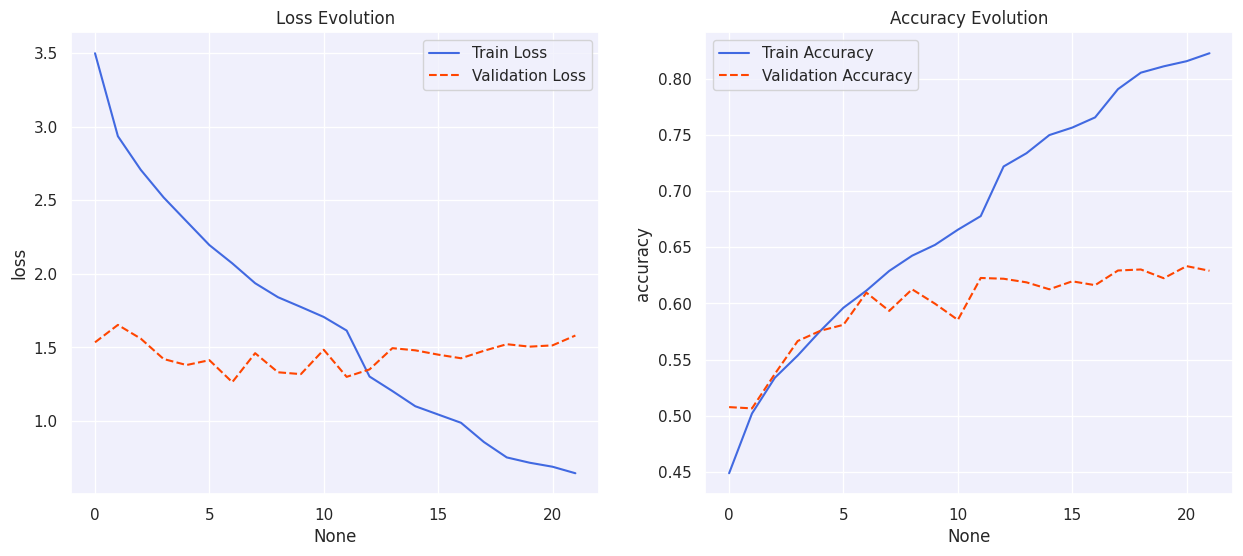

In [117]:
plot_learning_curves(history, start_epoch=1)

In [119]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

137/137 [==============================] - 15s 106ms/step
               precision    recall  f1-score   support

      Battery       0.68      0.78      0.72        32
     Clothing       1.00      0.29      0.45        92
General trash       0.45      0.52      0.48       778
        Glass       0.83      0.40      0.54       211
        Metal       0.46      0.39      0.42       191
        Paper       0.76      0.71      0.74      1154
   Paper pack       0.57      0.54      0.56       168
      Plastic       0.79      0.24      0.37       545
  Plastic bag       0.60      0.86      0.71      1008
    Styrofoam       0.47      0.75      0.58       181

     accuracy                           0.61      4360
    macro avg       0.66      0.55      0.56      4360
 weighted avg       0.65      0.61      0.59      4360





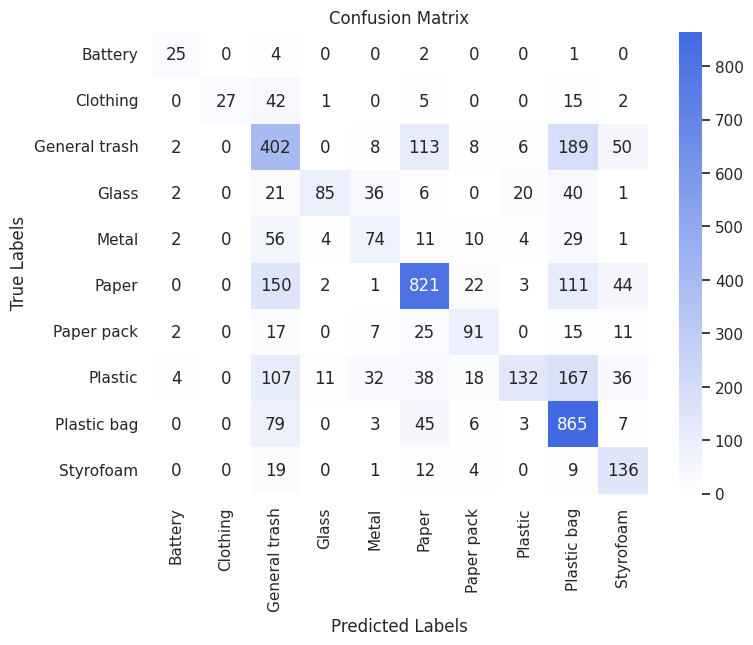

In [120]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)

In [29]:
transfer_resnet50_model.load_weights('best_model_weights.h5')
predictions = transfer_resnet50_model.predict(val_generator, steps=len(val_generator))

2024-10-22 16:34:35.760166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2024-10-22 16:34:36.037952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


137/137 [==============================] - 16s 106ms/step


In [30]:
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

index_to_class = {v: k for k, v in train_generator.class_indices.items()}  # {'Battery': 0, 'Clothing': 1, ...}를 뒤집음

class_to_new_id = {
    'General trash': 0,
    'Paper': 1,
    'Paper pack': 2,
    'Metal': 3,
    'Glass': 4,
    'Plastic': 5,
    'Styrofoam': 6,
    'Plastic bag': 7,
    'Battery': 8,
    'Clothing': 9
}

predicted_labels = [index_to_class[i] for i in predicted_classes]
predicted_new_ids = [class_to_new_id[label] for label in predicted_labels]

results_df = pd.DataFrame({
    'filepath': val_df['filepath'],        # 테스트 이미지 파일 경로
    'label' : predicted_labels,
    'label_id': predicted_new_ids,  # 새로운 label_id
    'cs': confidence_scores   # 각 예측의 신뢰도 (confidence score)
})

results_df.to_csv('test.csv', index=False)
print(results_df.head())


                                            filepath          label  label_id  \
0  /hdd1/lim_data/level2_dataset/crop_val_4/4_13_...          Paper         1   
1  /hdd1/lim_data/level2_dataset/crop_val_4/4_14_...      Styrofoam         6   
2  /hdd1/lim_data/level2_dataset/crop_val_4/4_15_...          Paper         1   
3  /hdd1/lim_data/level2_dataset/crop_val_4/4_16_...          Paper         1   
4  /hdd1/lim_data/level2_dataset/crop_val_4/4_17_...  General trash         0   

         cs  
0  0.738244  
1  0.600851  
2  0.305345  
3  0.834759  
4  0.587382  
